In [1]:
import igraph as ig
import scipy.sparse
import re
from collections import Counter

from maxent_graph import bicm, poibin

Let's try projecting a bipartite network of senators and bills onto the senators. The data comes from the 116th congress, https://github.com/unitedstates/congress/wiki/bills

Read the graph in and construct a bipartite matrix using igraph.

In [2]:
gn = "my_senate_116_bipartite"
g = ig.read(f"../data/{gn}.graphml", format="graphml")
assert g.is_bipartite()
B = scipy.sparse.csr_matrix(g.get_incidence()[0])

In [3]:
B

<4464x101 sparse matrix of type '<class 'numpy.int64'>'
	with 31589 stored elements in Compressed Sparse Row format>

By convention we project onto the rows. In this case I want the senators, who are on the columns currently. So, I transpose.

In [4]:
B = B.T

Solve the equations to get the fitnesses for each node on both sides.

In [5]:
# sol_bundle = bicm.solve_equations_kitchen_sink(B)
sol_bundle = bicm.solve_equations(B, initial_guess_option=2, method="lm")

In [6]:
B.shape

(101, 4464)

Using the previously computed fitnesses, construct the projection using a particular p-value. To keep a record of *how* significant the edge is according to the null model, we keep the 'surprise' of the edge as a weight.

In [7]:
new_A = bicm.construct_projection(B, sol_bundle, p_val=0.05)

Let's visualize the results using igraph. Getting this weighted adjacency matrix into igraph is a bit annoying but here goes.. 

https://igraph.org/python/doc/tutorial/tutorial.html#layouts-and-plotting

In [8]:
sources, targets = new_A.nonzero()
edgelist = list(zip(sources.tolist(), targets.tolist()))

# https://github.com/igraph/python-igraph/issues/168
# zzz
new_g = ig.Graph(new_A.shape[0], edgelist)

new_g.es['surprise'] = new_A[new_A.nonzero()].toarray()[0]

In [9]:
(new_g.vcount(), new_g.ecount())

(101, 1665)

In [10]:
# l = new_g.layout_kamada_kawai()
# l = new_g.layout_lgl()
l = new_g.layout_fruchterman_reingold(weights=new_g.es["surprise"])

# trash
# l = new_g.layout_drl(weights=new_g.es["surprise"])

Leiden is a good quick community detection algorithm.

In [11]:
clusters = new_g.community_leiden(objective_function='CPM',
                              weights=new_g.es["surprise"],
                              resolution_parameter=0.5, beta=0.01,
                              initial_membership=None, n_iterations=10, node_weights=None)

In [12]:
for c in clusters:
    print(c)

[0, 2, 4, 6, 8, 9, 11, 13, 17, 20, 22, 23, 24, 25, 26, 29, 30, 32, 33, 35, 36, 39, 42, 43, 44, 45, 46, 49, 52, 55, 58, 59, 62, 63, 67, 71, 72, 73, 75, 76, 78, 81, 82, 84, 85, 88, 90, 91, 92, 98, 100]
[1, 3, 5, 7, 10, 12, 14, 15, 16, 18, 19, 21, 27, 28, 31, 34, 37, 38, 40, 41, 47, 48, 50, 51, 53, 57, 60, 61, 64, 65, 68, 70, 74, 77, 79, 80, 83, 86, 87, 89, 93, 94, 95, 96, 97, 99]
[54, 66]
[56]
[69]


In [13]:
# https://carto.com/carto-colors/
PASTEL_CARTO = ['#66C5CC','#F6CF71','#F89C74','#DCB0F2','#87C55F','#9EB9F3',
                '#FE88B1','#C9DB74','#8BE0A4','#B497E7','#D3B484','#B3B3B3']

In [14]:
assert len(clusters) <= len(PASTEL_CARTO)

In [15]:
community_assignment = [0 for _ in range(new_g.vcount())]

for i, c in enumerate(clusters):
    for v in c:
        community_assignment[v] = i

In [16]:
new_g.vs['color'] = [PASTEL_CARTO[c] for c in community_assignment]

In [17]:
party_re = re.compile(".*\(..-(D|R|I)\)")

party = []
senator_names = g.vs['name'][:(B.shape[0])]
for n in senator_names:
    m = party_re.match(n)
    if m is None:
        print(n)
    p = m.group(1)
    party.append(p)
    
Counter(party)

Counter({'R': 54, 'D': 45, 'I': 2})

In [18]:
senator_names[0]

'Alexander, L. (TN-R)'

In [19]:
def map_party(p):
    if p == 'R':
        return 'square'
    elif p == 'D':
        return 'triangle'
    elif p == 'I':
        return 'circle'
    assert False

In [20]:
shapes = [map_party(p) for p in party]

In [21]:
shapes[:5]

['square', 'triangle', 'square', 'triangle', 'square']

In [22]:
new_g.vs['shape'] = shapes
new_g.vs['label'] = senator_names
new_g.vs['label_size'] = [7 for v in new_g.vs]

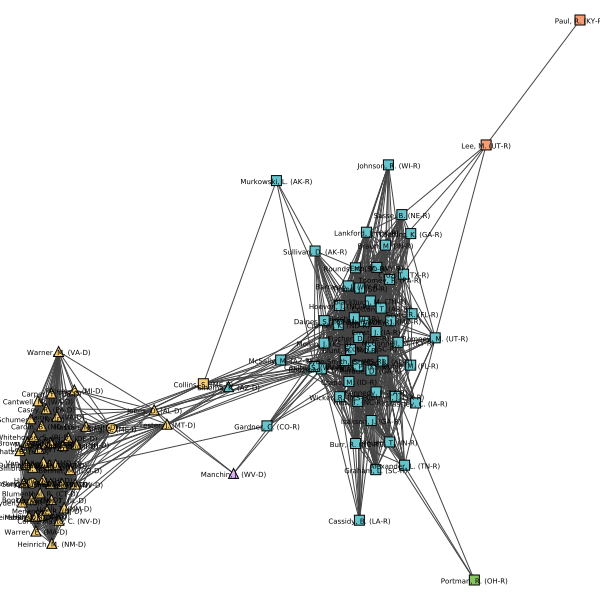

In [23]:
ig.plot(new_g, layout=l, vertex_size=10)